<a href="https://colab.research.google.com/github/fboldt/aulasml/blob/master/aula06b_random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [111]:
from sklearn.datasets import load_iris
dataset = load_iris()
X = dataset.data
y = dataset.target

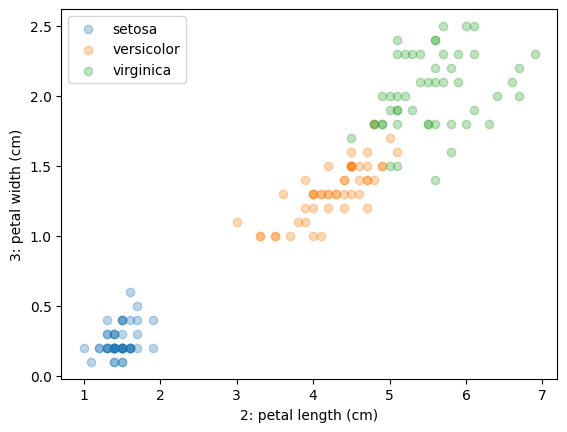

In [112]:
import matplotlib.pyplot as plt
i, j = 2, 3
def plot_features(i, j):
  plt.xlabel(f"{i}: {dataset.feature_names[i]}")
  plt.ylabel(f"{j}: {dataset.feature_names[j]}")
def plot_dataset(X, y):
  for k in set(y):
      plt.scatter(X[y == k, 0], X[y == k, 1], label=dataset.target_names[k], alpha=0.3)
plot_features(i, j)
plot_dataset(X[:,[i,j]], y)
plt.legend()
plt.show()

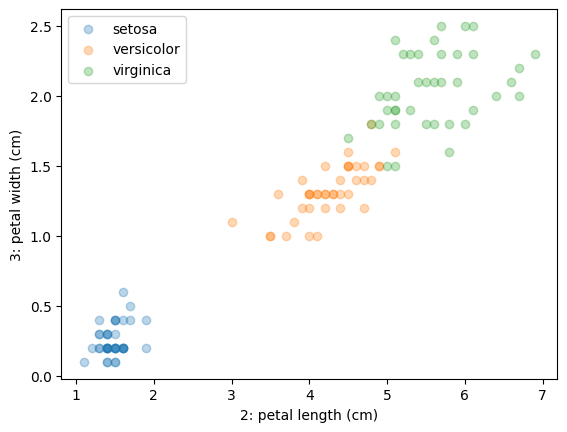

In [113]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X[:,[i,j]], y, test_size=0.2, random_state=42, stratify=y)
plot_features(i, j)
plot_dataset(X_train, y_train)
plt.legend()
plt.show()

In [114]:
from collections import Counter

def most_common(lst):
  data = Counter(lst)
  return data.most_common(1)[0][0]


In [116]:
import numpy as np

def defineAxes(X):
    offset = 0.1
    min1, max1 = X[:, 0].min(), X[:, 0].max()
    min2, max2 = X[:, 1].min(), X[:, 1].max()
    return [min1-offset, max1+offset, min2-offset, max2+offset]

def plotPredictions(clf, X):
    axes = defineAxes(X)
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)

In [117]:
def print_tree(model, level=0):
  if hasattr(model, 'answer'):
    print('  '*level, f"answer: {model.answer} n={model.n_samples}")
  else:
    print('  '*level, f"feature: {model.feature}")
    print_tree(model.greaters, level+1)
    print_tree(model.lessers, level+1)


In [118]:
from random import randint, uniform

def get_feat_value(X, y):
  feature = randint(0, X.shape[1]-1)
  value = uniform(X[:, feature].min(), X[:, feature].max())
  return feature, value


0.9


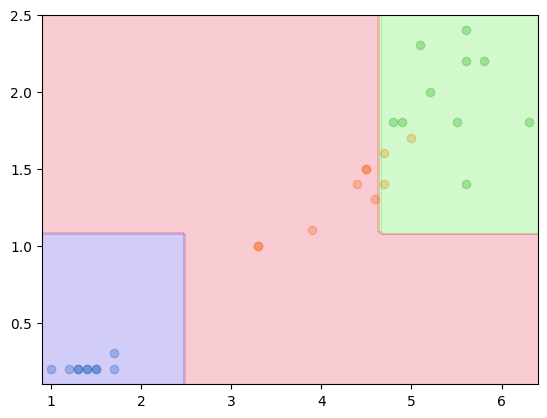

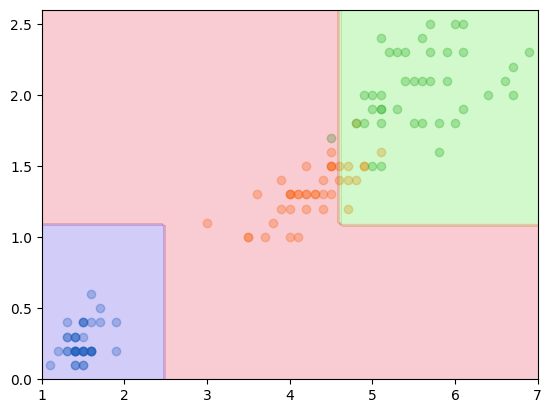

 feature: 1
   feature: 0
     answer: 2 n=47
     answer: 1 n=28
   feature: 0
     answer: 1 n=5
     answer: 0 n=40


In [122]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score

class DecisionTree(BaseEstimator, ClassifierMixin):
  def __init__(self, min_samples_leaf=2, max_depth=100):
    self.min_samples_leaf = min_samples_leaf
    self.max_depth = max_depth

  def fit(self, X, y):
    self.feature, self.value = get_feat_value(X, y)
    greater_values = X[:, self.feature] >= self.value
    if sum(greater_values)>=self.min_samples_leaf and \
       sum(~greater_values)>=self.min_samples_leaf and \
       self.max_depth > 0:
      self.greaters = DecisionTree(min_samples_leaf=self.min_samples_leaf,
                                   max_depth=self.max_depth-1).fit(X[greater_values], y[greater_values])
      self.lessers = DecisionTree(min_samples_leaf=self.min_samples_leaf,
                                   max_depth=self.max_depth-1).fit(X[~greater_values], y[~greater_values])
    else:
      self.n_samples = len(y)
      self.answer = most_common(y)
    return self

  def predict(self, X):
    if hasattr(self, 'answer'):
      return np.array([self.answer] * len(X))
    else:
      greater_values = X[:, self.feature] >= self.value
      return np.where(greater_values, self.greaters.predict(X), self.lessers.predict(X))

model = DecisionTree(max_depth=2)
model.fit(X_train, y_train)
ypred = model.predict(X_test)
print(accuracy_score(y_test, ypred))
plot_dataset(X_test, y_test)
plotPredictions(model, X_test)
plt.show()
plot_dataset(X_train, y_train)
plotPredictions(model, X_train)
plt.show()
print_tree(model)

In [132]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from pprint import pprint

scores = cross_validate(model, X, y, cv=KFold(shuffle=True))
pprint(scores['test_score'])
print(np.mean(scores['test_score']))

array([0.56666667, 0.83333333, 0.4       , 0.43333333, 0.53333333])
0.5533333333333333


0.9333333333333333


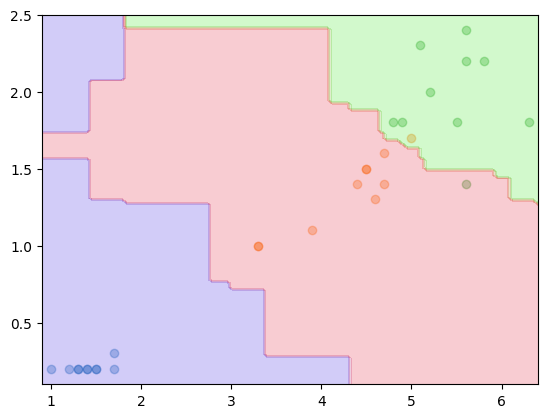

In [166]:
from sklearn.base import clone

class VotingClassifier(BaseEstimator, ClassifierMixin):
  def __init__(self, base_estimator=DecisionTree(), n_estimators=10):
    self.base_estimator = base_estimator
    self.n_estimators = n_estimators

  def fit(self, X, y):
    self.estimators_ = []
    for i in range(self.n_estimators):
      estimator = clone(self.base_estimator)
      estimator.fit(X, y)
      self.estimators_.append(estimator)
    return self

  def predict(self, X):
    predictions = []
    for estimator in self.estimators_:
      predictions.append(estimator.predict(X))
    ypred = np.apply_along_axis(most_common, 0, np.array(predictions))
    return ypred

model = VotingClassifier(n_estimators=10)
model.fit(X_train, y_train)
ypred = model.predict(X_test)
print(accuracy_score(y_test, ypred))
plot_dataset(X_test, y_test)
plotPredictions(model, X_test)
plt.show()

In [159]:
scores = cross_validate(model, X, y, cv=KFold(shuffle=True))
pprint(scores['test_score'])
print(np.mean(scores['test_score']))

array([0.96666667, 0.9       , 1.        , 0.96666667, 0.9       ])
0.9466666666666667
